Fragment vocabulary size: 53


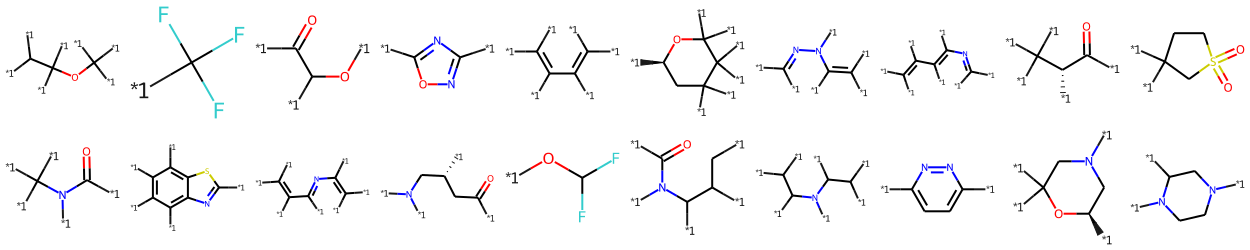

In [1]:
import selfies as sf
from group_selfies.group_mol_graph import Group
from group_selfies.group_grammar import GroupGrammar
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.drawMolsSameScale = False # DrawMolsZoomed
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
# RDLogger.EnableLog('rdApp.*')
from tdc import Oracle
sascore = Oracle('SA')
qed = Oracle('QED')
import matplotlib.pyplot as plt
import numpy as np
from group_selfies.utils.fragment_utils import fragment_mols
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import re
import random
m = Chem.MolFromSmiles
def grid(mols, molsPerRow=10):
    return Draw.MolsToGridImage(mols, molsPerRow=molsPerRow, maxMols=1000, subImgSize=(125, 125), useSVG=True)

def split_selfies(selfies: str):

    left_idx = selfies.find("[")

    while 0 <= left_idx < len(selfies):
        right_idx = selfies.find("]", left_idx + 1)
        if right_idx == -1:
            raise ValueError("malformed SELFIES string, hanging '[' bracket")

        next_symbol = selfies[left_idx: right_idx + 1]
        yield next_symbol

        left_idx = right_idx + 1
        if selfies[left_idx: left_idx + 1] == ".":
            yield "."
            left_idx += 1

def shuffle(selfies):
    """
    Shuffle a SELFIES string.
    """
    return "".join(sorted(split_selfies(selfies), key=lambda x: random.random()))


# get some molecules from the ZINC dataset
zinc = [x.strip() for x in open('../tests/test_sets/zinc.csv')][1:]

# pick N random molecules from lines
#### if you try running this notebook you should reduce N to 1,000 or 10,000
N = 100_000
####
smis = random.sample(zinc, N)
selfis = [sf.encoder(smi) for smi in smis]

empty_grammar = GroupGrammar()

load_from_disk = True

if load_from_disk:
    grammar = GroupGrammar.from_file('useful30.txt') | GroupGrammar.essential_set() #load
else:
    # extracting a set of reasonable groups using fragmentation
    fragments = fragment_mols(smis, convert=True, method='default', target=500) # use custom fragmentation technique
    vocab_fragment = dict([(f'frag{idx}', Group(f'frag{idx}', frag)) for idx, frag in enumerate(fragments)])
    grammar = GroupGrammar(vocab_fragment)
    grammar.to_file('zinc_test_grammar.txt')

print('Fragment vocabulary size:', len(grammar.vocab))
display(grid([g.mol for g in grammar.vocab.values()][:20]))

100%|██████████| 100000/100000 [00:09<00:00, 10420.74it/s]


Length of SELFIES strings: 37.45 +/- 8.47 tokens
Total number of SELFIES tokens: 3745264


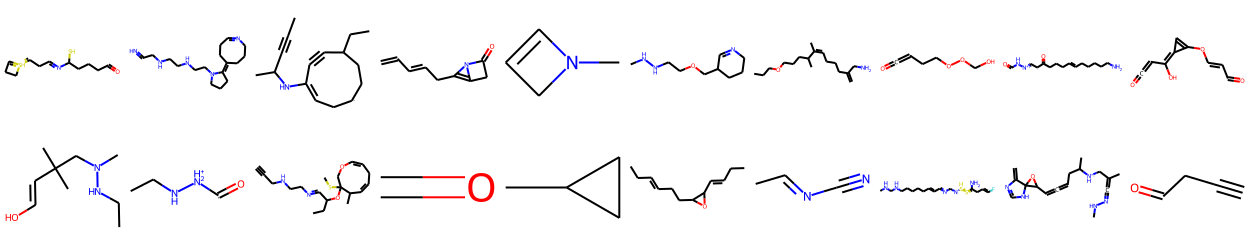

In [2]:
# split all selfies into tokens
split_selfis = [list(split_selfies(selfi)) for selfi in selfis]
# count the number of tokens in each selfi
selfi_lengths = [len(selfi) for selfi in split_selfis]

# combine all tokens from split_selfis into one list
selfi_alphabet = [token for selfi in split_selfis for token in selfi]

# generate random selfies strings from the alphabet
gen_selfi_smis = []
gen_selfis = []
for i in tqdm(range(N)):
    while True:
        gen_selfi = ''.join(random.sample(selfi_alphabet, random.choice(selfi_lengths)))
        gen_selfi_smi = sf.decoder(gen_selfi)
        if gen_selfi_smi != '':
            break
    gen_selfis.append(gen_selfi)
    gen_selfi_smis.append(gen_selfi_smi)

# decode into RDKit moles
gen_selfi_mols = [m(smi) for smi in gen_selfi_smis]

print(f"Length of SELFIES strings: {np.mean(selfi_lengths):.2f} +/- {np.std(selfi_lengths):.2f} tokens")
print(f"Total number of SELFIES tokens: {len(selfi_alphabet)}")

grid(gen_selfi_mols[:20])

Encoding... Done encoding


100%|██████████| 100000/100000 [02:17<00:00, 727.53it/s]


Length of Group SELFIES strings: 29.90 +/- 8.10
Total number of Group SELFIES tokens: 2989871


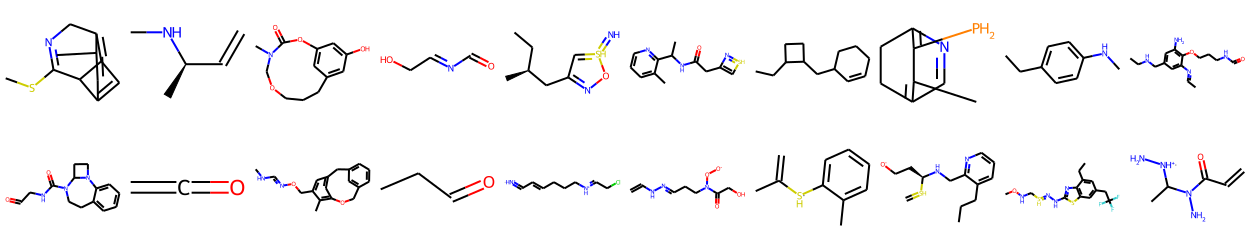

In [3]:
# encode all molecules into Group SELFIES
# grammar = GroupGrammar.from_file('zinc_test_grammar.txt') | GroupGrammar.essential_set()
def g_encoder(smi):
    # grammar = GroupGrammar.from_file('zinc_test_grammar.txt')
    encoded = grammar.full_encoder(m(smi))
    decoded = Chem.MolToSmiles(grammar.decoder(encoded))
    assert Chem.CanonSmiles(smi) == decoded, (smi, decoded, len(grammar.vocab))
    return encoded

print('Encoding... ', end='')
with Pool() as p:
    gselfis = p.map(g_encoder, smis)
print('Done encoding')

# # split all selfies into tokens
split_gselfis = [list(split_selfies(selfi)) for selfi in gselfis]

# # count the number of tokens in each selfi
gselfi_lengths = [len(selfi) for selfi in split_gselfis]

# # combine all tokens from split_selfis into one list
gselfi_alphabet = [token for selfi in split_gselfis for token in selfi]

gen_gselfis = []
gen_gselfi_smis = []
for i in tqdm(range(N)):
    while True:
        gen_gselfi = ''.join(random.sample(gselfi_alphabet, random.choice(gselfi_lengths)))
        gen_gselfi_mol = grammar.decoder(gen_gselfi)
        gen_gselfi_smi = Chem.MolToSmiles(gen_gselfi_mol)
        if gen_gselfi_smi != '':
            break
    gen_gselfis.append(gen_gselfi)
    gen_gselfi_smis.append(gen_gselfi_smi)

# decode into RDKit moles
gen_gselfi_mols = [m(smi) for smi in gen_gselfi_smis]

print(f"Length of Group SELFIES strings: {np.mean(gselfi_lengths):.2f} +/- {np.std(gselfi_lengths):.2f}")
print(f"Total number of Group SELFIES tokens: {len(gselfi_alphabet)}")

grid(gen_gselfi_mols[:20])

100%|██████████| 100000/100000 [02:02<00:00, 816.40it/s]


Length of Substring SELFIES strings: 40.92 +/- 13.71


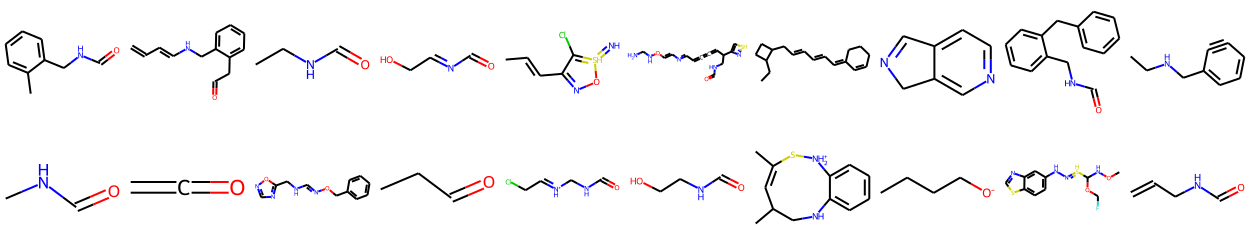

In [4]:
substring_dict = dict()
for key, val in grammar.vocab.items():

    gmol = Chem.RWMol(val.mol)
    remove = []
    for atom in val.mol.GetAtoms():
        if atom.GetSymbol() == '*':
            remove.append(atom.GetIdx())

    for i in reversed(remove):
        gmol.RemoveAtom(i)

    substring_dict[key] = empty_grammar.full_encoder(m(Chem.MolToSmiles(gmol)))

gen_subgselfis = []
subgselfi_lengths = []
for gen_gselfi in gen_gselfis:
    substring_gselfi = ''
    for tok in split_selfies(gen_gselfi):
        match = re.search(r"\[:(.*?)\d+(.*)\]", tok)
        if match is not None:
            substring_gselfi += substring_dict[match.group(2)]
        else:
            substring_gselfi += tok
    gen_subgselfis.append(substring_gselfi)
    subgselfi_lengths.append(len(list(split_selfies(substring_gselfi))))

gen_subgselfi_smis = [Chem.MolToSmiles(empty_grammar.decoder(selfi)) for selfi in tqdm(gen_subgselfis)]
gen_subgselfi_mols = [m(smi) for smi in gen_subgselfi_smis]

print(f"Length of Substring SELFIES strings: {np.mean(subgselfi_lengths):.2f} +/- {np.std(subgselfi_lengths):.2f}")

grid(gen_subgselfi_mols[:20])

100%|██████████| 100000/100000 [02:09<00:00, 773.47it/s]


Length of Group SELFIES strings with no groups: 38.87 +/- 8.64
Total number of Group SELFIES tokens with no groups: 3887371


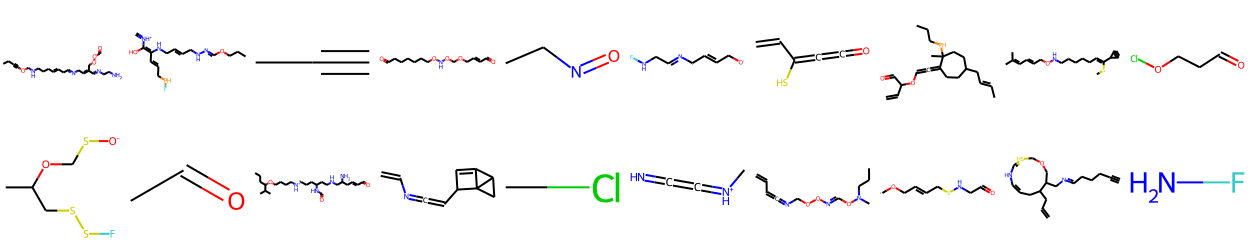

In [5]:
# group selfies with no groups

# encode all molecules into Group SELFIES
nogselfis = [empty_grammar.full_encoder(m(smi)) for smi in tqdm(smis)]

# split all selfies into tokens
split_nogselfis = [list(split_selfies(selfi)) for selfi in nogselfis]

# count the number of tokens in each selfi
nogselfi_lengths = [len(selfi) for selfi in split_nogselfis]

# combine all tokens from split_selfis into one list
nogselfi_alphabet = [token for selfi in split_nogselfis for token in selfi]

gen_nogselfis = []
gen_nogselfi_smis = []
for i in tqdm(range(N)):
    while True:
        gen_nogselfi = ''.join(random.sample(nogselfi_alphabet, random.choice(nogselfi_lengths)))
        gen_nogselfi_mol = grammar.decoder(gen_nogselfi)
        gen_nogselfi_smi = Chem.MolToSmiles(gen_nogselfi_mol)
        if gen_nogselfi_smi != '':
            break
    gen_nogselfis.append(gen_nogselfi)
    gen_nogselfi_smis.append(gen_nogselfi_smi)

# decode into RDKit moles
gen_nogselfi_mols = [m(smi) for smi in gen_nogselfi_smis]

print(f"Length of Group SELFIES strings with no groups: {np.mean(nogselfi_lengths):.2f} +/- {np.std(nogselfi_lengths):.2f}")
print(f"Total number of Group SELFIES tokens with no groups: {len(nogselfi_alphabet)}")

grid(gen_nogselfi_mols[:20])

In [6]:
with Pool() as p:
    sascores = p.map(sascore, smis)
    qeds = p.map(qed, smis)
    selfi_sascores = p.map(sascore, gen_selfi_smis)
    selfi_qeds = p.map(qed, gen_selfi_smis)
    gselfi_sascores = p.map(sascore, gen_gselfi_smis)
    gselfi_qeds = p.map(qed, gen_gselfi_smis)
    subgselfi_sascores = p.map(sascore, gen_subgselfi_smis)
    subgselfi_qeds = p.map(qed, gen_subgselfi_smis)
    nogselfi_sascores = p.map(sascore, gen_nogselfi_smis)
    nogselfi_qeds = p.map(qed, gen_nogselfi_smis)

In [7]:
import pandas as pd

values = "ZINC|Group SELFIES|SELFIES|Substring SELFIES|No-Group SELFIES".split('|')
cat_order = "ZINC|Group SELFIES|SELFIES|Substring SELFIES|No-Group SELFIES".split('|')
df = pd.DataFrame({"ZINC": sascores, "SELFIES": selfi_sascores, "Group SELFIES": gselfi_sascores, "Substring SELFIES": subgselfi_sascores, "No-Group SELFIES": nogselfi_sascores})
df = df.melt(value_vars=values, var_name="Type", value_name="SAScore").drop("Type", axis=1)

smiles_df = pd.DataFrame({"ZINC": smis, "SELFIES": gen_selfi_smis, "Group SELFIES": gen_gselfi_smis, "Substring SELFIES": gen_subgselfi_smis, "No-Group SELFIES": gen_nogselfi_smis})
smiles_df = smiles_df.melt(value_vars=values, var_name="Type", value_name="SMILES")

qed_df = pd.DataFrame({"ZINC": qeds, "SELFIES": selfi_qeds, "Group SELFIES": gselfi_qeds, "Substring SELFIES": subgselfi_qeds, "No-Group SELFIES": nogselfi_qeds}).melt(value_vars=values, var_name="Type", value_name="QED").drop("Type", axis=1)
df = pd.concat([df, smiles_df, qed_df], axis=1)
df

,SAScore,Type,SMILES,QED
0,3.158266,ZINC,CCn1cc(Nc2scc(-c3cnn(C)c3)[n+]2CC)cn1,0.736505
1,2.594919,ZINC,CO[C@H]1CCCN(C(=O)NCCCS(=O)(=O)c2ccccc2)C1,0.799455
2,3.137829,ZINC,COc1cccc(C(=O)C2=C([O-])C(=O)N(Cc3ccco3)[C@@H]...,0.318508
3,3.914442,ZINC,C[C@@H](C#N)CN(C)C(=O)C1[C@H]2CCC[C@@H]12,0.704412
4,3.434072,ZINC,CN(C)c1ccc(NC(=O)NNc2ccc(F)c(F)c2F)c[nH+]1,0.595387
...,...,...,...,...
499995,5.021761,No-Group SELFIES,O=CP=C=CC=C1CCC1=COCCS,0.262736
499996,4.791800,No-Group SELFIES,NC=CCC=NC=CNCC=CCCOCCC=CCNC=C[O-],0.181754
499997,6.211491,No-Group SELFIES,[CH]CCCC=CCC=CC=CNC[NH+]C#[SH]1N2CCC=C(F)N21,0.088306
499998,4.330330,No-Group SELFIES,CC=CCC=NC=O,0.305255


In [8]:
cat_order

['ZINC', 'Group SELFIES', 'SELFIES', 'Substring SELFIES', 'No-Group SELFIES']

In [9]:
from scipy.stats import wasserstein_distance
counts, bin_edges = np.histogram(df.SAScore, bins='auto')

each_counts = []
for i in cat_order:
    counts, bin_edges = np.histogram(df[df.Type == i].SAScore, bins=bin_edges)
    each_counts.append(counts)

sascore_wassersteins = [wasserstein_distance(bin_edges[:-1], bin_edges[:-1], each_counts[0], each_counts[i]) for i in range(len(cat_order))]
sascore_wassersteins

[0.0,
 0.9639563113180848,
 1.6862664658150037,
 0.9912741542100763,
 1.8582890690725278]

In [10]:
from scipy.stats import wasserstein_distance
counts, bin_edges = np.histogram(df.QED, bins='auto')

each_counts = []
for i in cat_order:
    counts, bin_edges = np.histogram(df[df.Type == i].QED, bins=bin_edges)
    each_counts.append(counts)

qed_wassersteins = [wasserstein_distance(bin_edges[:-1], bin_edges[:-1], each_counts[0], each_counts[i]) for i in range(len(cat_order))]
qed_wassersteins

[0.0,
 0.2939788010837019,
 0.368444469932407,
 0.3197663234679077,
 0.40189585208412454]

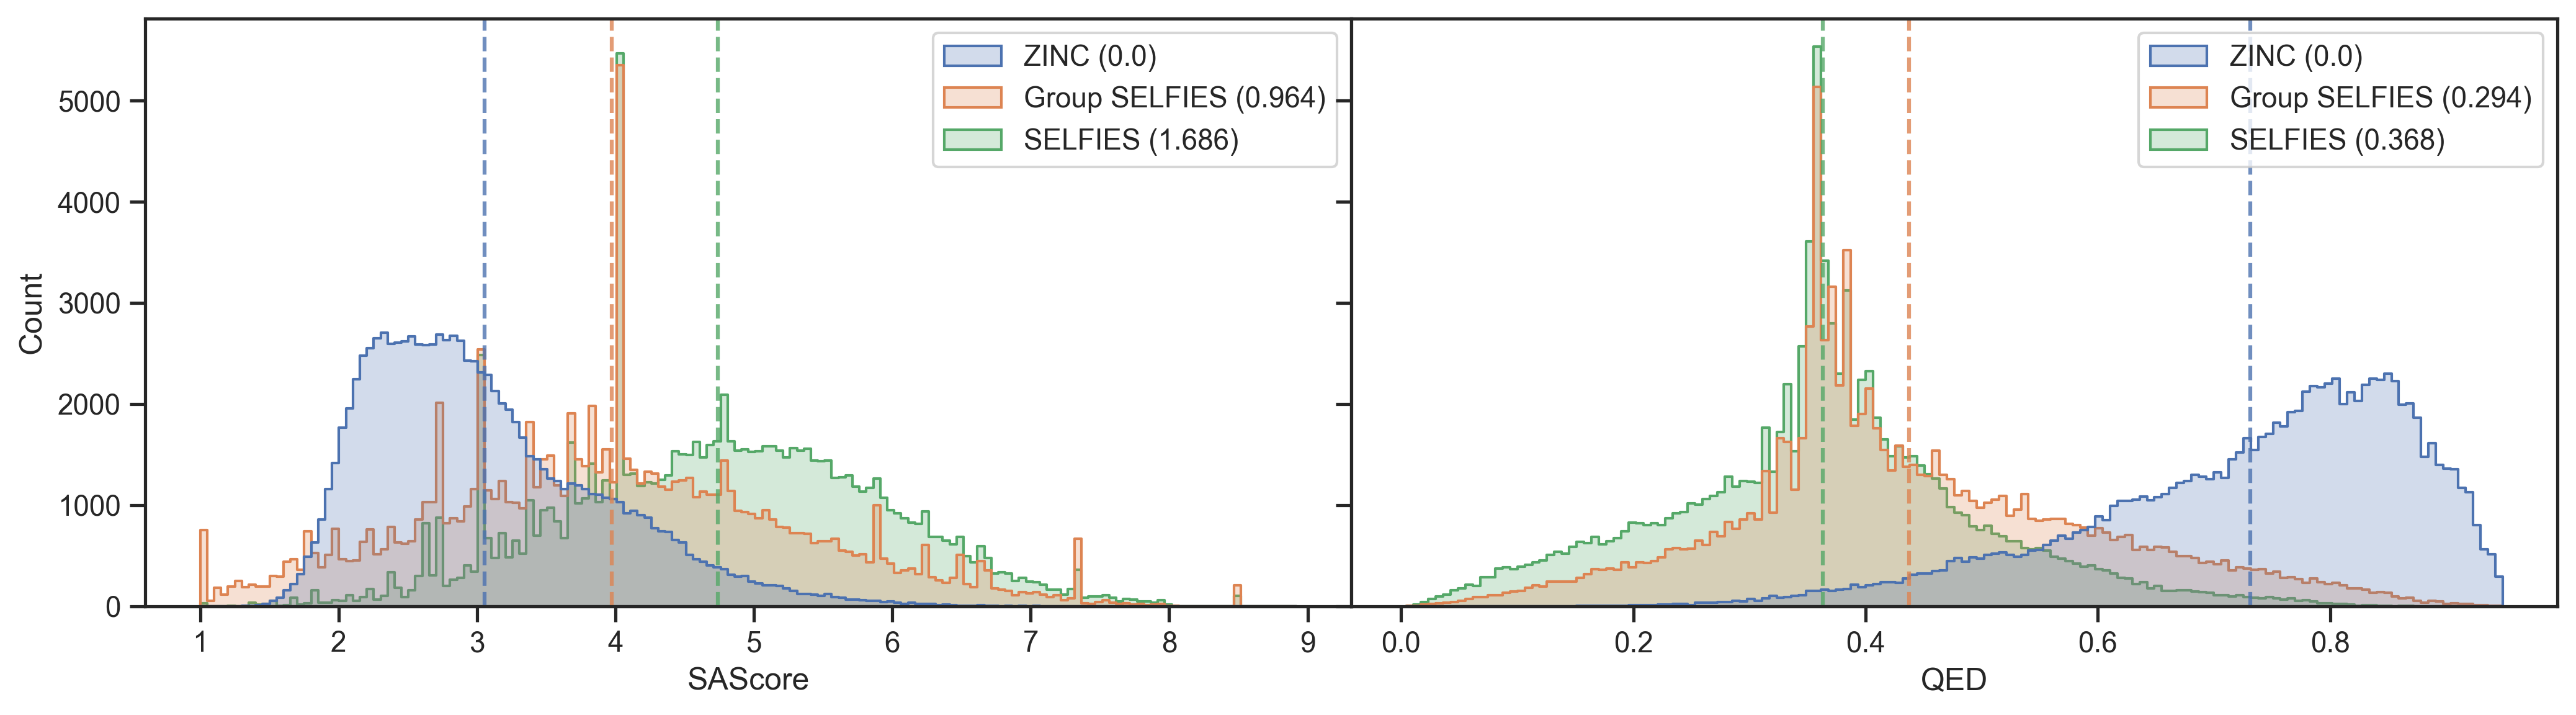

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# show means and show wasserstein distance

indices = [0, 1, 2]

my_sascore_wass = [sascore_wassersteins[i] for i in indices]
my_cat_order = [cat_order[i] for i in indices]
my_qed_wass = [qed_wassersteins[i] for i in indices]

sns.set(style="ticks")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True, dpi=300)
sns.histplot(data=df, x="SAScore", hue="Type", ax=ax1, hue_order=my_cat_order, element='step')
leg = ax1.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_sascore_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax1.axvline(df[df.Type == cat].SAScore.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

sns.histplot(data=df, x="QED", hue="Type", ax=ax2, hue_order=my_cat_order, element='step')
sns.move_legend(ax2, 'upper right')
leg = ax2.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_qed_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax2.axvline(df[df.Type == cat].QED.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('figures/zinc_gselfi_selfi.png')

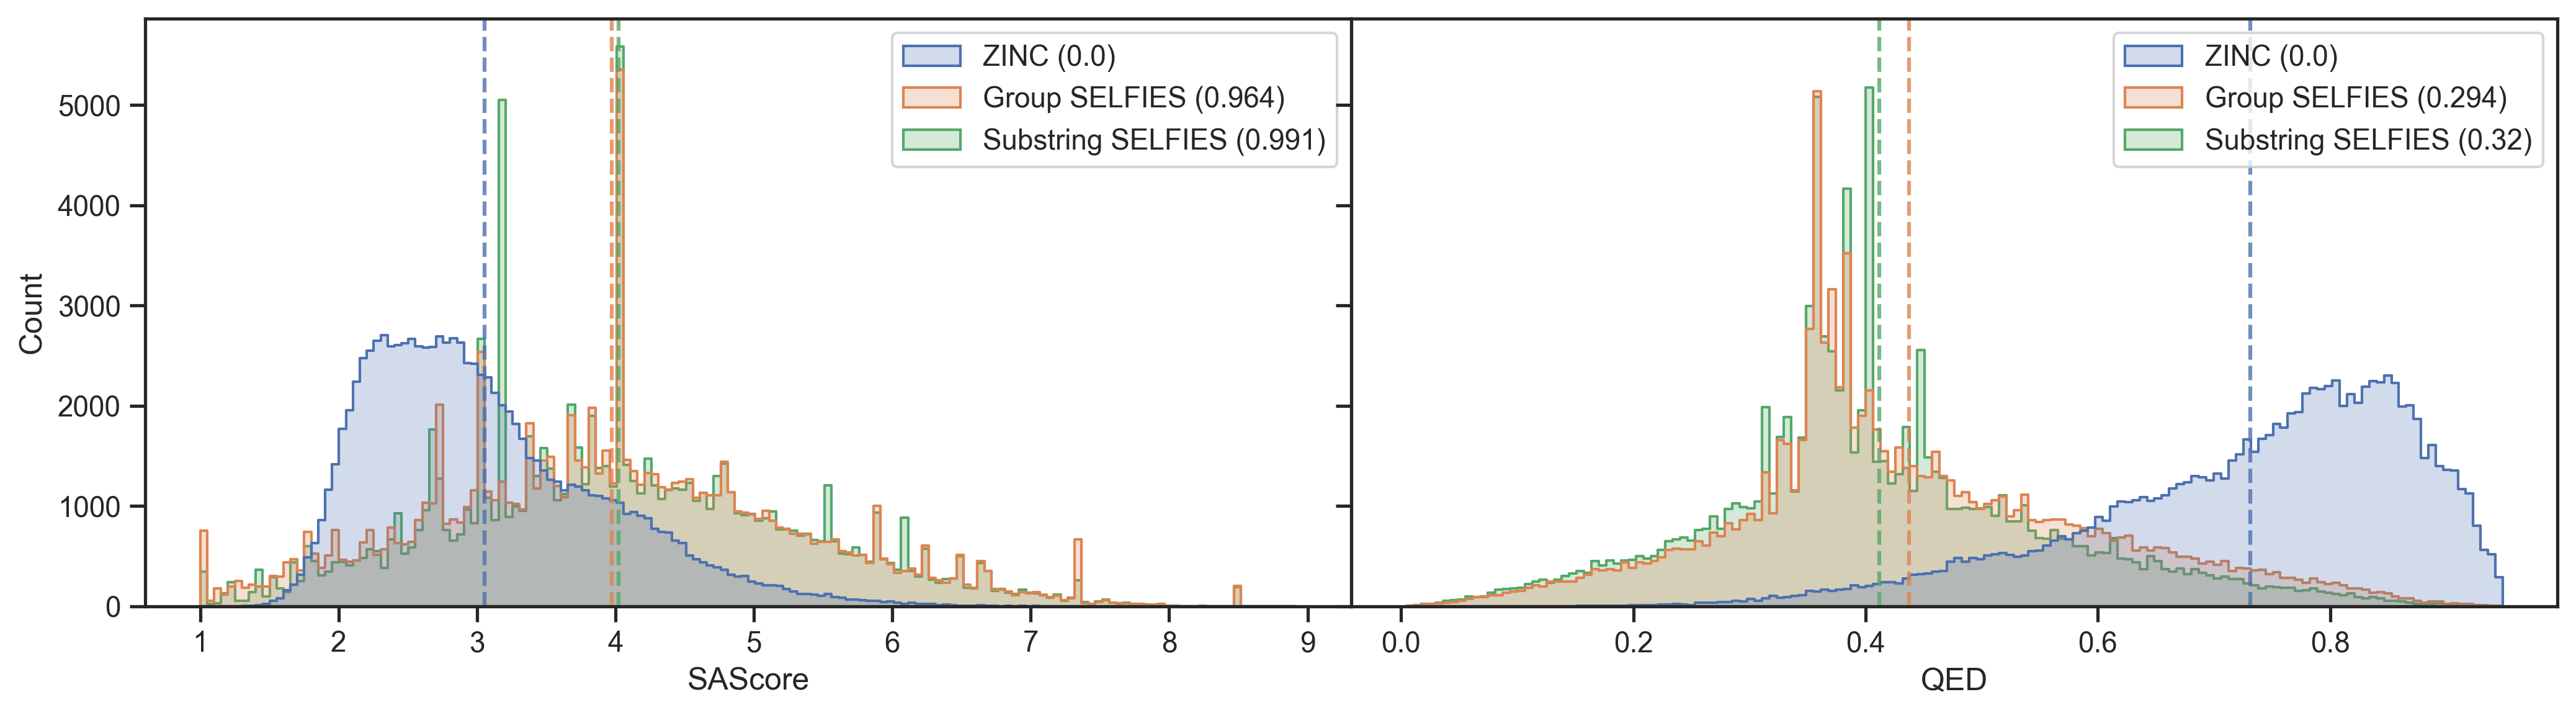

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# show means and show wasserstein distance

indices = [0, 1, 3]

my_sascore_wass = [sascore_wassersteins[i] for i in indices]
my_cat_order = [cat_order[i] for i in indices]
my_qed_wass = [qed_wassersteins[i] for i in indices]

sns.set(style="ticks")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True, dpi=300)
sns.histplot(data=df, x="SAScore", hue="Type", ax=ax1, hue_order=my_cat_order, element='step')
leg = ax1.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_sascore_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax1.axvline(df[df.Type == cat].SAScore.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

sns.histplot(data=df, x="QED", hue="Type", ax=ax2, hue_order=my_cat_order, element='step')
sns.move_legend(ax2, 'upper right')
leg = ax2.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_qed_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax2.axvline(df[df.Type == cat].QED.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('figures/zinc_gselfi_subselfi.png')

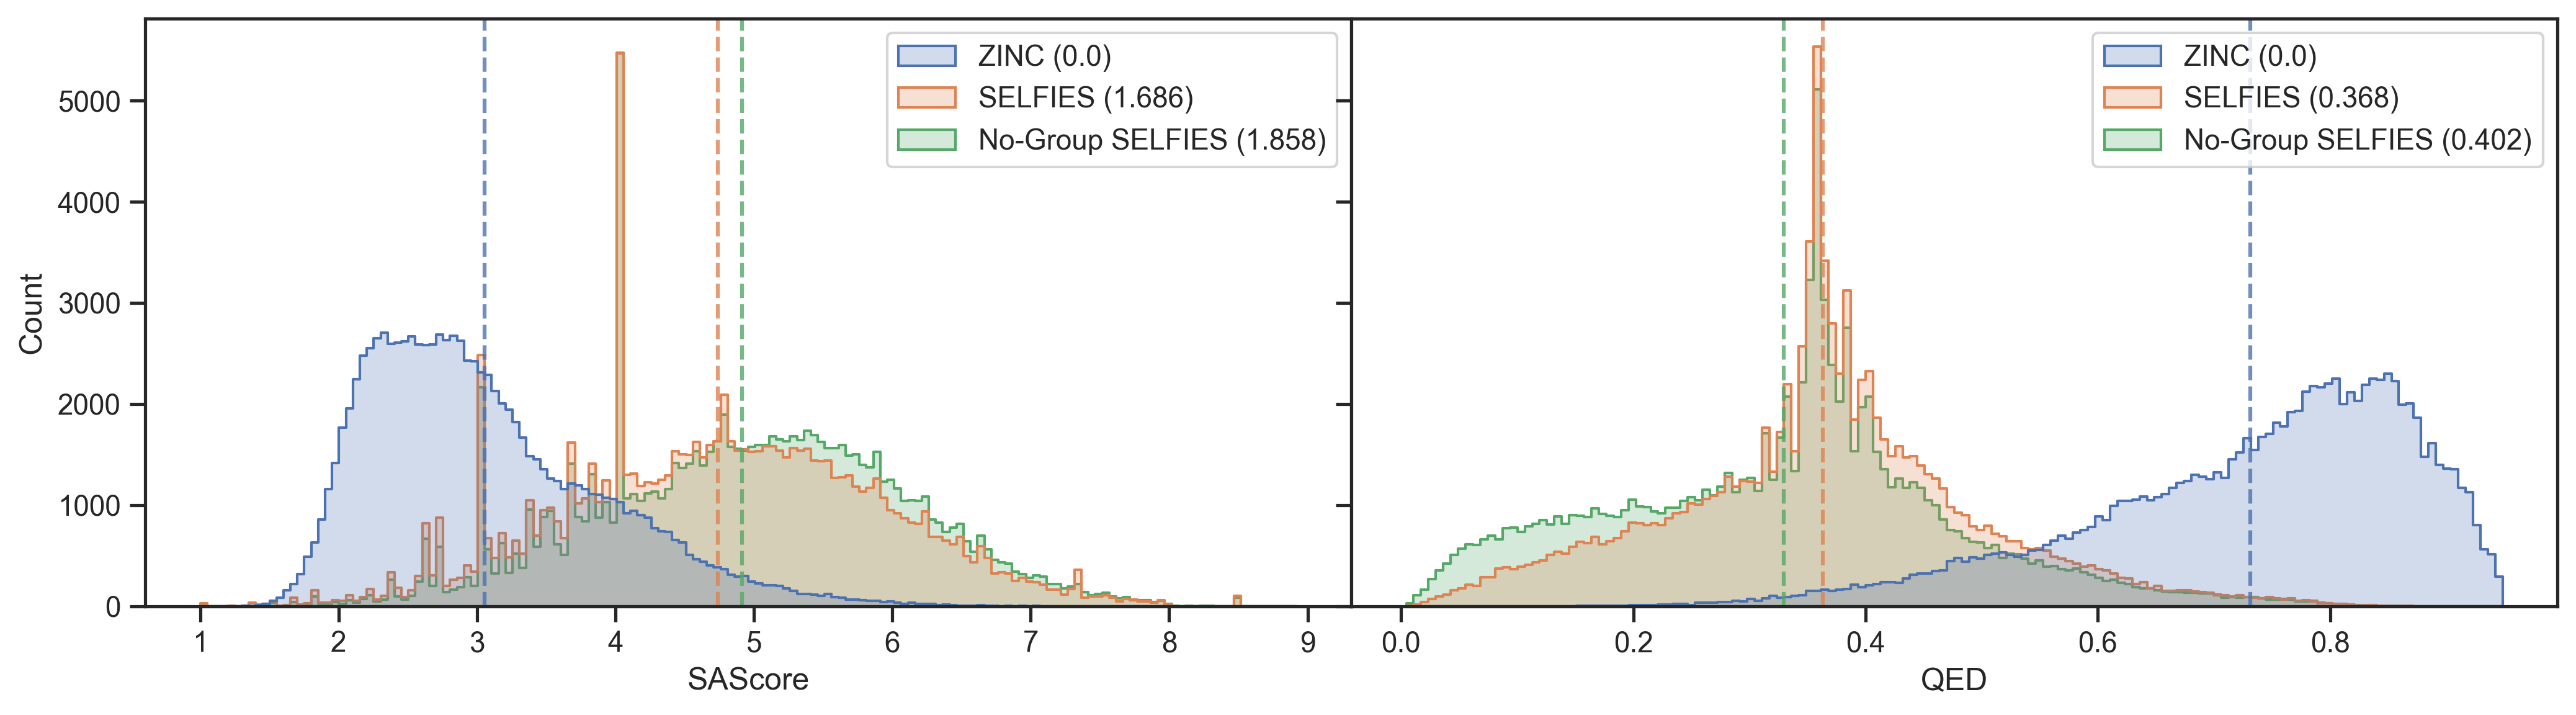

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# show means and show wasserstein distance

indices = [0, 2, 4]

my_sascore_wass = [sascore_wassersteins[i] for i in indices]
my_cat_order = [cat_order[i] for i in indices]
my_qed_wass = [qed_wassersteins[i] for i in indices]

sns.set(style="ticks")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), sharey=True, dpi=300)
sns.histplot(data=df, x="SAScore", hue="Type", ax=ax1, hue_order=my_cat_order, element='step')
leg = ax1.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_sascore_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax1.axvline(df[df.Type == cat].SAScore.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

sns.histplot(data=df, x="QED", hue="Type", ax=ax2, hue_order=my_cat_order, element='step')
sns.move_legend(ax2, 'upper right')
leg = ax2.get_legend()
leg.set_title(None)

for i, tex in enumerate(leg.get_texts()):
    tex.set_text(tex.get_text() + f' ({round(my_qed_wass[i], 3)})')

for i, cat in enumerate(my_cat_order):
    ax2.axvline(df[df.Type == cat].QED.mean(), color=f'C{i}', linestyle='--', alpha=0.8)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('figures/zinc_selfi_nogselfi.png')

In [14]:
import plotly.express as px
import molplotly

fig = px.violin(df, y="SAScore", x="Type", box=True, points="all", hover_data=df.columns, category_orders=cat_order)

app = molplotly.add_molecules(fig=fig,
                               df=df,)
app.run_server(mode='inline', port=8703)

In [15]:
import plotly.express as px
import molplotly

fig = px.violin(df, y="QED", x="Type", box=True, points="all", hover_data=df.columns, category_orders=cat_order)

app = molplotly.add_molecules(fig=fig,
                               df=df,)
app.run_server(mode='inline', port=8704)